# VAE

参考  
1. https://arxiv.org/pdf/1312.6114.pdf : 元論文  
2. https://ralo23.hatenablog.com/entry/2016/08/26/163556 : 理論理解に使った記事  
3. https://tips-memo.com/vae-pytorch : 実装に使った記事（理論部分の記述には間違いが多いので注意）

In [ ]:
# 必要なライブラリのインポート
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
import torch.utils as utils
from torchvision import datasets, transforms

In [ ]:
# deviceの定義
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# データセットのロード
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1))])

dataset_train = datasets.MNIST(
    'mnist', 
    train=True, 
    download=True, 
    transform=transform)
dataset_valid = datasets.MNIST(
    'mnist', 
    train=False, 
    download=True, 
    transform=transform)

batch_size = 100

dataloader_train = utils.data.DataLoader(dataset_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4)
dataloader_valid = utils.data.DataLoader(dataset_valid,
                                          batch_size=1000,
                                          shuffle=True,
                                          num_workers=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# モデルの定義
class VAE(nn.Module):
  def __init__(self, x_dim, z_dim):
    super(VAE, self).__init__()

    # Encoder
    self.x_dim = x_dim
    self.z_dim = z_dim
    self.fc1 = nn.Linear(x_dim, 200)
    self.bn1 = nn.BatchNorm1d(200)
    self.fc2_mean = nn.Linear(200, z_dim)
    self.fc2_var = nn.Linear(200, z_dim)

    # Eecoder
    self.fc3 = nn.Linear(z_dim, 200)
    self.drop1 = nn.Dropout(p=0.2)
    self.fc4 = nn.Linear(200, x_dim)

  def encoder(self, x):
    x = x.view(-1, self.x_dim)
    x = F.relu(self.fc1(x))
    x = self.bn1(x)
    mean = self.fc2_mean(x) # 平均
    log_var = self.fc2_var(x) # 分散の対数（全結合層の出力が負の値になっても分散は正の値になる）
    return mean, log_var
  
  def sample_z(self, mean, log_var, device): # 潜在ベクトルをサンプリング
    epsilon = torch.randn(mean.shape, device=device)
    return mean + epsilon * torch.exp(0.5*log_var)

  def decoder(self, z):
    y = F.relu(self.fc3(z))
    y = self.drop1(y)
    y = torch.sigmoid(self.fc4(y)) # 各要素にシグモイド関数を適用し、値を(0,1)の範囲に
    return y

  def forward(self, x, device):
    x = x.view(-1, self.x_dim)
    mean, log_var = self.encoder(x)
    delta = 1e-8
    KL = -0.5 * torch.sum(1 + log_var - mean**2 - torch.exp(log_var))/ x.shape[0]# [1]
    z = self.sample_z(mean, log_var, device)
    y = self.decoder(z)
    reconstruction = torch.sum(x * torch.log(y + delta) + (1 - x) * torch.log(1 - y + delta))/ x.shape[0]
    # 再構成誤差、生成器にベルヌーイ分布を仮定
    # [1]
    lower_bound = reconstruction - KL # 変分下界
    return -lower_bound, z, y

[1]  
参考記事2や原論文を参照しながら読まれたい。  
- logp(x) ≥ L(変分下界) = Ez∼q(z|x)[logp(x|z)] − KL  である。
  - 左辺を見ると分かる様に、この式はあるxについての式であり、右辺も（基本的には）そのxを使えば表現できる。  
- 第一項が再構築に関する項（再構成誤差）、第二項がKLダイバージェンスである。  
  - 第二項のKLダイバージェンスは、解析的に計算することができる。参考記事2におけるdや、原論文のAppendixBにおけるJは、潜在変数zの次元数。   
  - 第一項については、モンテカルロ法により推定する（そのため実際には、右辺の計算には他のxも用いる）。参考記事2のLはモンテカルロ法におけるサンプリング数。
- 今回、バッチサイズはL=100である。
  - 第二項（コードにおけるreconstruction）はバッチサイズLで割られるべきであるので、x.shape[0]で割った。
  - そのため、参考記事2や原論文の記述に忠実にコーディングするならば、第一項（コードにおけるreconstruction）は  
  torch.sum(x * torch.log(y + delta) + (1 - x) * torch.log(1 - y + delta))  ***/ L***  
  というように、Lで割られているべきなので、x.shape[0]で割った。





In [ ]:
# 学習
model = VAE(x_dim=28*28, z_dim=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

num_epochs = 20
loss_list = []
for i in range(num_epochs):
  losses = []
  for x, t in dataloader_train:
    x = x.to(device)
    loss, z, y = model(x, device)
    model.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.cpu().detach().numpy())
  loss_list.append(np.average(losses))
  print("EPOCH: {} loss: {}".format(i, np.average(losses)))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EPOCH: 0 loss: 162.32339477539062
EPOCH: 1 loss: 133.33229064941406
EPOCH: 2 loss: 130.05609130859375
EPOCH: 3 loss: 128.25048828125
EPOCH: 4 loss: 127.12470245361328
EPOCH: 5 loss: 126.11196899414062
EPOCH: 6 loss: 125.4399642944336
EPOCH: 7 loss: 124.84480285644531
EPOCH: 8 loss: 124.43075561523438
EPOCH: 9 loss: 123.83377838134766
EPOCH: 10 loss: 123.532470703125
EPOCH: 11 loss: 123.18331909179688
EPOCH: 12 loss: 122.81988525390625
EPOCH: 13 loss: 122.67021179199219
EPOCH: 14 loss: 122.3853530883789
EPOCH: 15 loss: 122.03585815429688
EPOCH: 16 loss: 121.89096069335938
EPOCH: 17 loss: 121.6925277709961
EPOCH: 18 loss: 121.51863098144531
EPOCH: 19 loss: 121.36798095703125


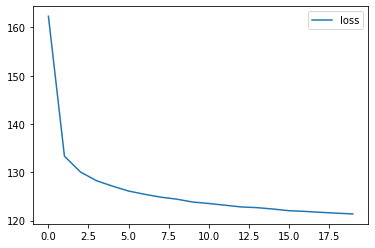

In [ ]:
# 学習結果
epoch_axis = np.arange(num_epochs)
plt.plot(epoch_axis, loss_list, label="loss")
plt.legend()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


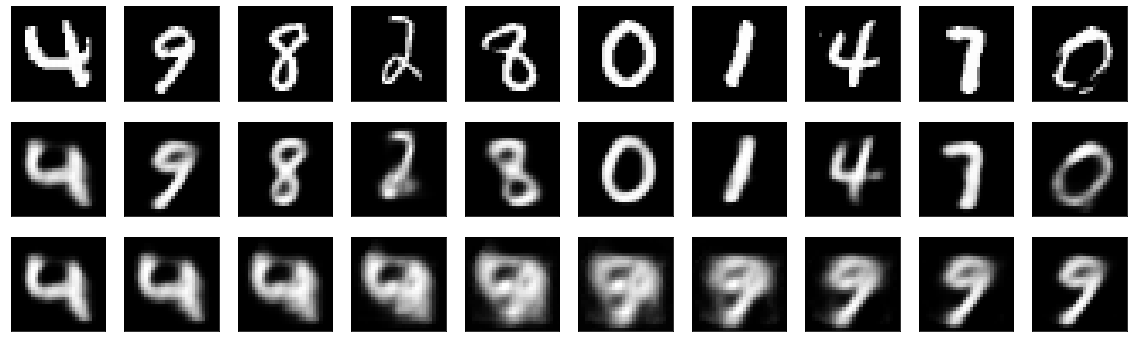

In [ ]:
# 生成
fig = plt.figure(figsize=(20, 6))

# 入力画像
model.eval()
zs = []
x, t = next(iter(dataloader_valid))
for i, im in enumerate(x.view(-1, 28, 28).detach().numpy()[:10]):
  ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
  ax.imshow(im, 'gray')

# 生成画像
x = x.to(device)
_, z, y = model(x, device)
zs.append(z)
y = y.view(-1, 28, 28)
for i, im in enumerate(y.cpu().detach().numpy()[:10]):
  ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
  ax.imshow(im, 'gray')

# 潜在変数空間において潜在変数を動かした（一つ目の生成画像→二つ目の生成画像）時の生成画像の変遷  
z1to0 = torch.cat([z[1, :] * (i * 0.1) + z[0, :] * ((10 - i) * 0.1) for i in range(10)]).reshape(10, 10)
y2 = model.decoder(z1to0).view(-1, 28, 28)
for i, im in enumerate(y2.cpu().detach().numpy()[:20]):
  ax = fig.add_subplot(3, 10, i+21, xticks=[], yticks=[])
  ax.imshow(im, 'gray')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


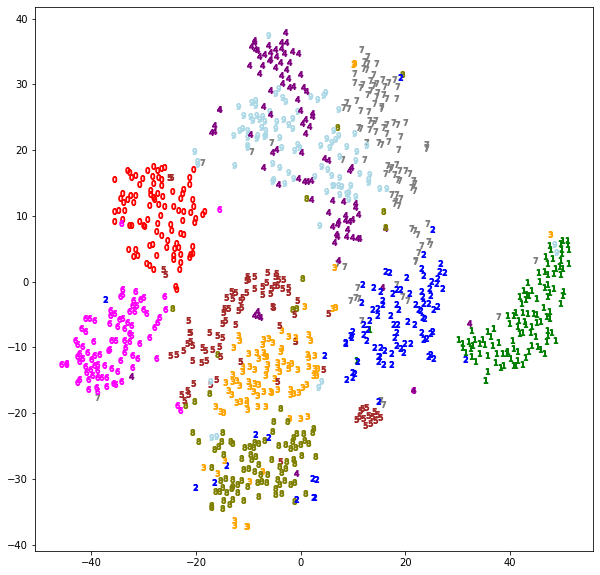

In [ ]:
# 分布の可視化
from sklearn.manifold import TSNE
from random import random

colors = ["red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue"]
def visualize_zs(zs, labels):
  plt.figure(figsize=(10,10))
  points = TSNE(n_components=2, random_state=0).fit_transform(zs)
  for p, l in zip(points, labels):
    plt.scatter(p[0], p[1], marker="${}$".format(l), c=colors[l])
  plt.show()

model.eval()
zs = []
x, t = next(iter(dataloader_valid))
x = x.to(device)
t = t.to(device)
# generate from x
_, z, y = model.forward(x, device)
z = z.cpu()
t = t.cpu()
visualize_zs(z.detach().numpy(), t.cpu().detach().numpy())